In [62]:
import pandas as pd
import numpy as np

# Data Exploration

##### Create tables

In [63]:
merged_df = pd.read_csv('data/opendata-with-labels.csv', index_col=0).fillna(0)
merged_df['gender.label'] = merged_df['gender.label'].apply(lambda label: 1 if label == 'male' else 0).apply(pd.to_numeric)

merged_df.head(5)


,"playful,serious","shy,bold","cheery,sorrowful","masculine,feminine","charming,awkward","lewd,tasteful","intellectual,physical","strict,lenient","refined,rugged","trusting,suspicious",...,"picky,always down","proactive,reactive","prudish,flirtatious","innocent,jaded","touchy-feely,distant","muddy,washed","quirky,predictable","never cries,often crying",race.label,gender.label
id,,,,,,,,,,,,,,,,,,,,,
WE/1,36.4,98.8,72.3,47.3,24.2,29.3,75.4,64.7,82.1,57.2,...,60.4,74.0,83.9,78.7,70.9,33.2,31.3,31.8,white,0
WE/2,57.4,89.2,64.7,13.8,19.2,45.0,67.5,38.9,80.4,54.2,...,73.9,65.0,93.3,81.0,66.0,28.1,41.7,27.5,white,1
WE/3,26.8,57.4,9.1,92.1,27.1,66.8,44.0,74.3,34.0,12.3,...,71.4,44.9,76.8,31.4,13.3,84.4,12.7,72.8,white,0
WE/4,56.9,74.4,28.2,58.4,27.7,76.2,30.6,58.3,33.7,35.7,...,65.4,29.8,82.3,49.3,25.2,72.2,55.8,35.9,white,0
WE/5,23.6,36.0,29.4,60.6,85.8,58.8,6.8,68.0,37.4,13.3,...,78.3,56.3,36.9,34.9,30.3,52.4,39.6,75.1,black,1


In [64]:
merged_df.shape

(1462, 402)

##### Standardize index names

In [65]:
traits_columns = list(filter(lambda col: ',' in col, merged_df.columns.values))

print('Total Dual Traits:', len(traits_columns))

Total Dual Traits: 400


In [66]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from datetime import datetime

def evaluate_classifier(label, model, classifier, X, y):
    
    start = datetime.now().timestamp()
    
    k_fold = KFold(n_splits=5)
    
    total_accuracy = 0
    total_tries = 0
    
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred, normalize=True)

        total_accuracy += accuracy
        total_tries += 1
        
    end = datetime.now().timestamp()
    print(f'{label} Accuracy using {model}:', round(total_accuracy / total_tries, 4), ' - seconds taken:', round(end-start, 2))


def test_classifier(label, model, classifier, X, y, test_size=0.25):
    
    start = datetime.now().timestamp()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred, normalize=True)

    end = datetime.now().timestamp()
    print(f'Final {label} Accuracy using {model}:', round(accuracy, 4), ' - seconds taken:', round(end-start, 2))

    



# Predict the Gender

In [67]:
from sklearn.linear_model import LassoCV, Ridge, RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# For gender prediction, we remove the 'masculine' label
gender_columns = list(filter(lambda trait: 'masculine' not in trait, traits_columns))

X = merged_df[gender_columns].values
y = merged_df['gender.label'].values


evaluate_classifier('Gender', 'AdaBoost', AdaBoostClassifier(), X, y)
evaluate_classifier('Gender', 'Decision Tree, vanilla ', DecisionTreeClassifier(), X, y)
evaluate_classifier('Gender', 'KNN - 3', KNeighborsClassifier(3), X, y)
evaluate_classifier('Gender', 'Logistic Regression L2', LogisticRegression(penalty='l2', max_iter=5000), X, y)
evaluate_classifier('Gender', 'Multi-layer Perceptron Adam (64)', MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(64,), max_iter=1000), X, y)
evaluate_classifier('Gender', 'Random Forest 2^8 estimators, Gini', RandomForestClassifier(n_estimators=2**8, criterion='gini'), X, y)
evaluate_classifier('Gender', 'Random Forest 2^8 estimators, Entropy', RandomForestClassifier(n_estimators=2**8, criterion='entropy'), X, y)
evaluate_classifier('Gender', 'Ridge Classifier, alpha 0.1', RidgeClassifier(alpha=0.1), X, y)
evaluate_classifier('Gender', 'SVM Poly (3)', svm.SVC(kernel='poly', degree=3, C=1.0), X, y)
evaluate_classifier('Gender', 'SVM Poly (5)', svm.SVC(kernel='poly', degree=5, C=1.0), X, y)

test_classifier('Gender', 'Logistic Regression L2', LogisticRegression(penalty='l2', max_iter=5000), X, y, test_size=0.33)
test_classifier('Gender', 'SVM Poly (3)', svm.SVC(kernel='poly', degree=3, C=1.0), X, y, test_size=0.33)
test_classifier('Gender', 'SVM Poly (5)', svm.SVC(kernel='poly', degree=5, C=1.0), X, y, test_size=0.33)


Gender Accuracy using AdaBoost: 0.9542  - seconds taken: 9.27
Gender Accuracy using Decision Tree, vanilla : 0.8618  - seconds taken: 1.62
Gender Accuracy using KNN - 3: 0.8488  - seconds taken: 0.97
Gender Accuracy using Logistic Regression L2: 0.9822  - seconds taken: 2.15
Gender Accuracy using Multi-layer Perceptron Adam (64): 0.9487  - seconds taken: 15.18
Gender Accuracy using Random Forest 2^8 estimators, Gini: 0.9199  - seconds taken: 11.81
Gender Accuracy using Random Forest 2^8 estimators, Entropy: 0.9213  - seconds taken: 17.49
Gender Accuracy using Ridge Classifier, alpha 0.1: 0.9815  - seconds taken: 0.12
Gender Accuracy using SVM Poly (3): 0.9849  - seconds taken: 0.75
Gender Accuracy using SVM Poly (5): 0.9863  - seconds taken: 0.76
Final Gender Accuracy using Logistic Regression L2: 0.9876  - seconds taken: 0.24
Final Gender Accuracy using SVM Poly (3): 0.9917  - seconds taken: 0.13
Final Gender Accuracy using SVM Poly (5): 0.9938  - seconds taken: 0.13


In [7]:
merged_df['gender.label'].value_counts()

1    889
0    573
Name: gender.label, dtype: int64

# Predict the Race

In [61]:
from sklearn.linear_model import LassoCV, Ridge, RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

# For gender prediction, we remove the 'masculine' label
#race_columns = list(traits_columns)
race_columns = list(filter(lambda trait: 'western' not in trait, traits_columns))
race_columns.append('gender.label')

y_encoder = LabelEncoder()

X = merged_df[race_columns].values
y = y_encoder.fit_transform(merged_df['race.label'])

evaluate_classifier('Race', 'AdaBoost', AdaBoostClassifier(), X, y)
evaluate_classifier('Race', 'Decision Tree, vanilla ', DecisionTreeClassifier(), X, y)
evaluate_classifier('Race', 'KNN - 3', KNeighborsClassifier(3), X, y)
evaluate_classifier('Race', 'Logistic Regression L2, 10000 iterations', LogisticRegression(penalty='l2', max_iter=10000), X, y)
evaluate_classifier('Race', 'Multi-layer Perceptron Adam (64)', MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(64,), max_iter=1000), X, y)
evaluate_classifier('Race', 'Random Forest 2^8 estimators, Gini', RandomForestClassifier(n_estimators=2**8, criterion='gini'), X, y)
evaluate_classifier('Race', 'Random Forest 2^8 estimators, Entropy', RandomForestClassifier(n_estimators=2**8, criterion='entropy'), X, y)
evaluate_classifier('Race', 'Ridge Classifier, alpha 0.1 SVD', RidgeClassifier(alpha=0.1, solver='svd'), X, y)
evaluate_classifier('Race', 'SVM Poly (3)', svm.SVC(kernel='poly', degree=3, C=1.0), X, y)
evaluate_classifier('Race', 'SVM Poly (5)', svm.SVC(kernel='poly', degree=5, C=1.0), X, y)

test_classifier('Race', 'Random Forest 2^8 estimators, Entropy', RandomForestClassifier(n_estimators=2**8, criterion='entropy'), X, y, test_size=0.33)
test_classifier('Race', 'Ridge Classifier, alpha 0.1', RidgeClassifier(alpha=0.1), X, y, test_size=0.33)
#test_classifier('Race', 'SVM Poly (3)', svm.SVC(kernel='poly', degree=3, C=1.0), X, y, test_size=0.33)
#test_classifier('Race', 'SVM Poly (5)', svm.SVC(kernel='poly', degree=5, C=1.0), X, y, test_size=0.33)


Race Accuracy using Ridge Classifier, alpha 0.1 SVD: 0.8824  - seconds taken: 2.44
Race Accuracy using Ridge Classifier, alpha 0.1 Cholesky: 0.8824  - seconds taken: 0.14
Race Accuracy using Ridge Classifier, alpha 0.1 lsqr: 0.8851  - seconds taken: 0.49
Race Accuracy using Ridge Classifier, alpha 0.1 sag: 0.8837  - seconds taken: 21.01
Race Accuracy using Ridge Classifier, alpha 0.1 saga: 0.8851  - seconds taken: 30.97


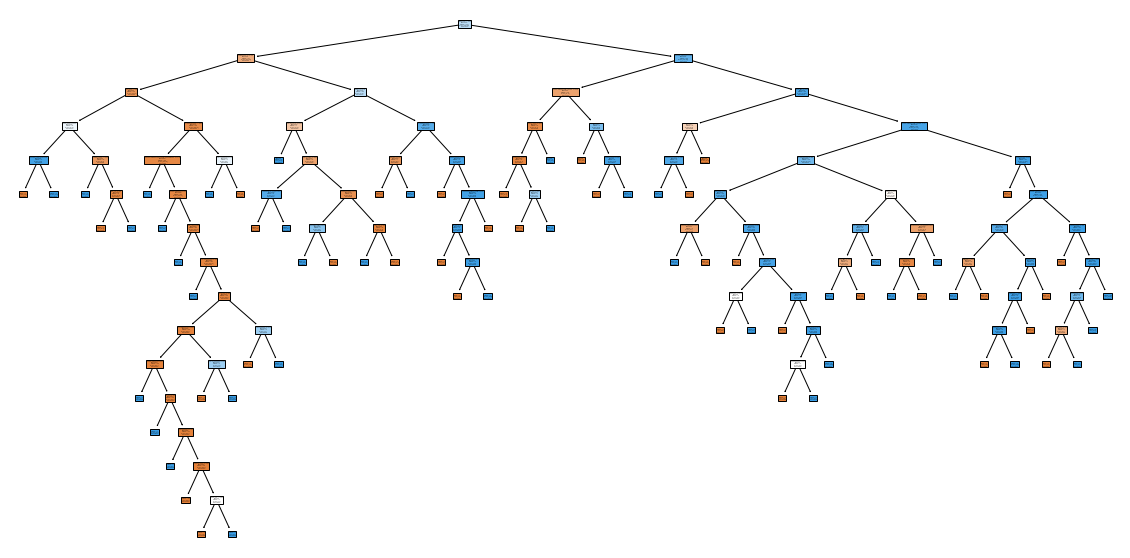

In [85]:
from sklearn import tree
from matplotlib import pyplot as plt

decision_tree_classifier = DecisionTreeClassifier(criterion='gini')  
decision_tree_classifier.fit(X, y)



fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(decision_tree_classifier, 
                   feature_names=race_columns,  
                   class_names=y_encoder.classes_,
                   filled=True,
                   label='all')

In [10]:
merged_df['race.label'].value_counts()['white'] / len(merged_df['race.label'])

0.8180574555403557

In [11]:
merged_df['race.label'].value_counts()

white              1196
black               136
asian                60
hispanic             54
mideast               7
indian                7
native american       2
Name: race.label, dtype: int64

In [12]:
len(merged_df['race.label'])

1462